<a href="https://colab.research.google.com/github/istiaksaif/CSE445_BigMart_Sales_Prediction/blob/main/MLProject(BigMart).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from google.colab import drive

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Data Analysis

In [ ]:
#loading dataset from drive (csvfile)
bigmart_data = pd.read_csv('/content/drive/MyDrive/CSE445/BigMart Dataset/Train.csv')
bigmart_test_data = pd.read_csv('/content/drive/MyDrive/CSE445/BigMart Dataset/Test.csv')
submission = pd.read_csv('/content/drive/MyDrive/CSE445/BigMart Dataset/Submission.csv')

In [ ]:
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
#number of Features and points
bigmart_data.shape


(8523, 12)

In [ ]:
#info about datatype
bigmart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
#check unique values
bigmart_data.apply(lambda x: len(x.unique()))

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [ ]:
#static info
bigmart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800




**Categorical Features**

*   Item_Identifier
*   Item_Weight
*   Item_Fat_Content
*   Item_Visibility
*   Item_Type
*   Item_MRP
*   Outlet_Identifier
*   Outlet_Establishment_Year
*   Outlet_Size
*   Outlet_Location_Type
*   Outlet_Type
*   Item_Outlet_Sales

#Preprocessing Dataset

In [ ]:
bigmart_test_data.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
#missing values
bigmart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
#check categorical attributes
cat_column =[]
for x in bigmart_data.dtypes.index:
  if bigmart_data.dtypes[x] == 'object':
    cat_column.append(x)
cat_column

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [ ]:
cat_column.remove('Item_Identifier')
cat_column.remove('Outlet_Identifier')
cat_column

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [ ]:
#print categorical columns
for col in cat_column:
  print(col)
  print(bigmart_data[col].value_counts())
  print()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int6

In [ ]:
#Average value of item_weight
Item_Weight_avg = bigmart_data['Item_Weight'].mean()
Item_Weight_avg

12.857645184136183

In [ ]:
#missing values in item_weight inpalce by average value
bigmart_data['Item_Weight'].fillna(Item_Weight_avg, inplace = True)
bigmart_test_data['Item_Weight'].fillna(Item_Weight_avg, inplace = True)

In [ ]:
#check missing values item_weight after fillup by average value
bigmart_data['Item_Weight'].isnull().sum()

0

In [ ]:
#Replace the missing values in outlet_size

outlet_size_mode = bigmart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
outlet_size_mode


Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [ ]:
missing_values_outlet = bigmart_data['Outlet_Size'].isnull()
missing_values_outlet

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [ ]:
#missing values in outlet_size repalce
bigmart_data.loc[missing_values_outlet,'Outlet_Size'] = bigmart_data.loc[missing_values_outlet,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [ ]:
#check missing values after replace outlet_size
bigmart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
#test data missing values in outlet_size repalce
missing_values_outlet = bigmart_test_data['Outlet_Size'].isnull()
bigmart_test_data.loc[missing_values_outlet,'Outlet_Size'] = bigmart_test_data.loc[missing_values_outlet,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

In [ ]:
bigmart_test_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [ ]:
sum(bigmart_data['Item_Visibility']==0)

526

In [ ]:
bigmart_data.loc[:,'Item_Visibility'].replace([0],[bigmart_data['Item_Visibility'].mean()],inplace=True)

In [ ]:
sum(bigmart_data['Item_Visibility']==0)

0

**Creation New Attributes**

In [ ]:
bigmart_data['new_item_type'] = bigmart_data['Item_Identifier'].apply(lambda x: x[:2])
bigmart_data['new_item_type']

0       FD
1       DR
2       FD
3       FD
4       NC
        ..
8518    FD
8519    FD
8520    NC
8521    FD
8522    DR
Name: new_item_type, Length: 8523, dtype: object

In [ ]:
bigmart_data['new_item_type'] = bigmart_data['new_item_type'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drink'})
bigmart_data['new_item_type'].value_counts()

Food              6125
Non-Consumable    1599
Drink              799
Name: new_item_type, dtype: int64

In [ ]:
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,new_item_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable


**Data Analysis**

In [ ]:
#Numerical features

sns.set()

<Figure size 432x432 with 0 Axes>

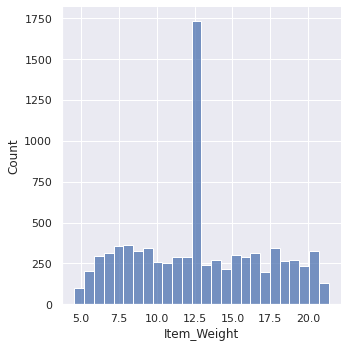

In [ ]:
#item_weight distribution
plt.figure(figsize=(6,6))
sns.displot(bigmart_data['Item_Weight'])
plt.show()

<Figure size 432x432 with 0 Axes>

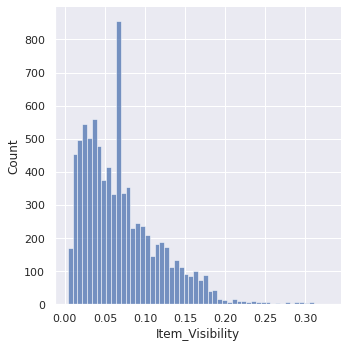

In [ ]:
 #Item_Visibility distribution
plt.figure(figsize=(6,6))
sns.displot(bigmart_data['Item_Visibility'])
plt.show()

<Figure size 432x432 with 0 Axes>

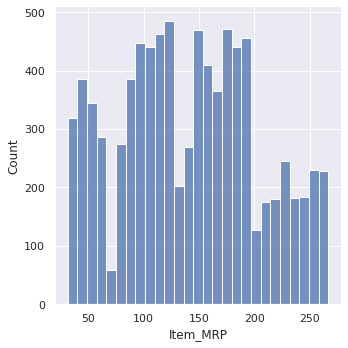

In [ ]:
#Item_MRP distribution
plt.figure(figsize=(6,6))
sns.displot(bigmart_data['Item_MRP'])
plt.show()

<Figure size 432x432 with 0 Axes>

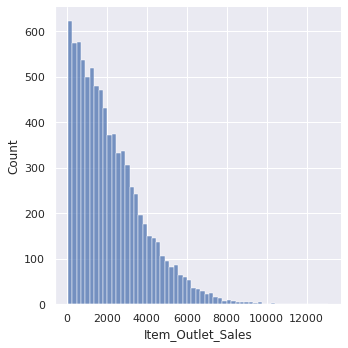

In [ ]:
#Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.displot(bigmart_data['Item_Outlet_Sales'])
plt.show()

In [ ]:
bigmart_data['Item_Outlet_Sales'] = np.log(1+bigmart_data['Item_Outlet_Sales'])

In [ ]:
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,new_item_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.225808,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.096776,Drink
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.648868,Food
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,6.597664,Food
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.903451,Non-Consumable


<Figure size 432x432 with 0 Axes>

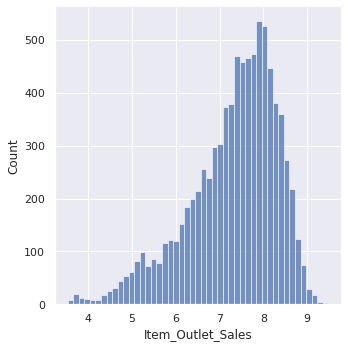

In [ ]:
plt.figure(figsize=(6,6))
sns.displot(bigmart_data['Item_Outlet_Sales'])
plt.show()

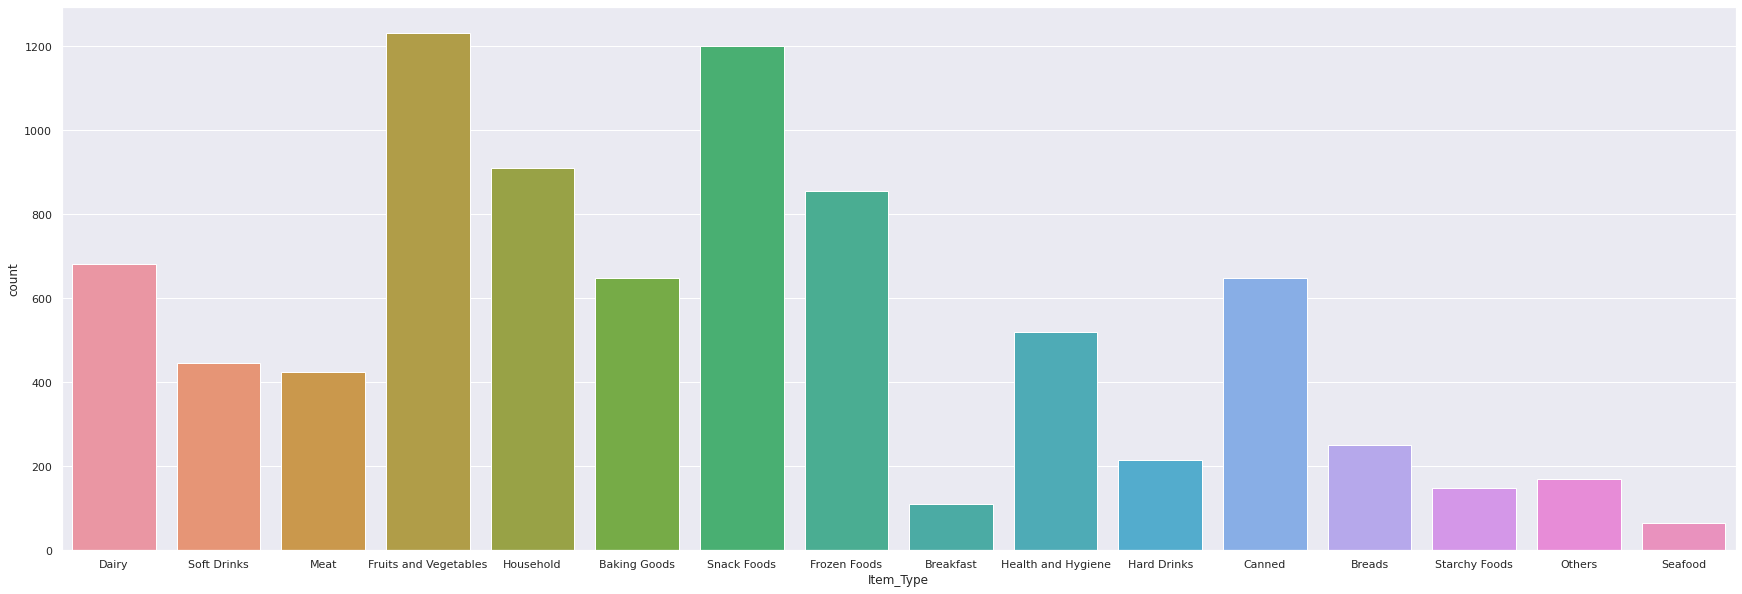

In [ ]:
#Item_Type_distribution
plt.figure(figsize=(30,10))
sns.countplot(x ='Item_Type', data = bigmart_data)
plt.show()

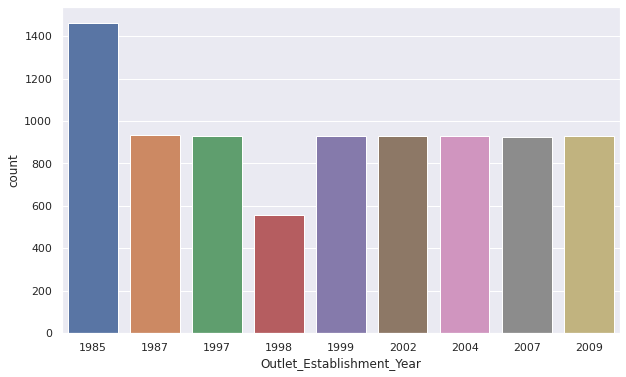

In [ ]:
#Outlet_Establishment_Year
plt.figure(figsize=(10,6))
sns.countplot(x ='Outlet_Establishment_Year', data = bigmart_data)
plt.show()

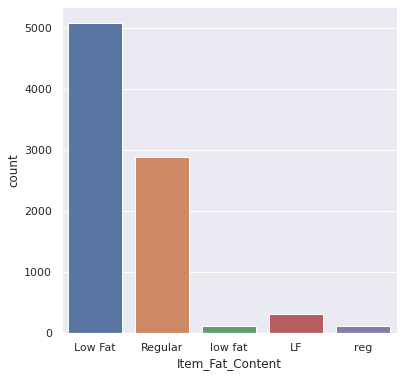

In [ ]:
#Item_Fat_Content_column
plt.figure(figsize=(6,6))
sns.countplot(x ='Item_Fat_Content', data = bigmart_data)
plt.show()

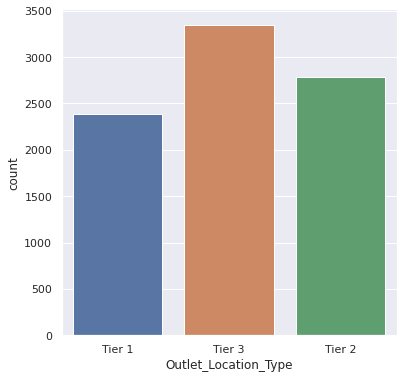

In [ ]:
#Outlet_Location_Type_column
plt.figure(figsize=(6,6))
sns.countplot(x ='Outlet_Location_Type', data = bigmart_data)
plt.show()

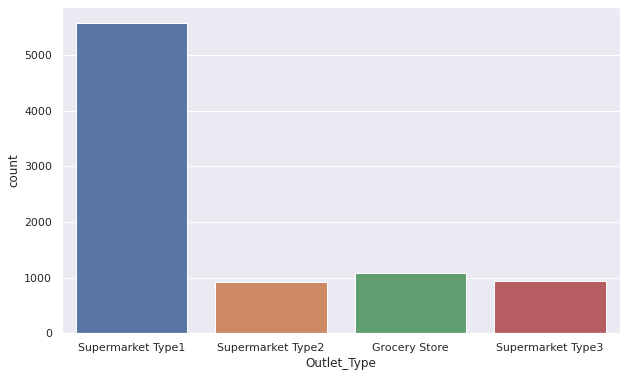

In [ ]:
#Outlet_Type_column
plt.figure(figsize=(10,6))
sns.countplot(x ='Outlet_Type', data = bigmart_data)
plt.show()

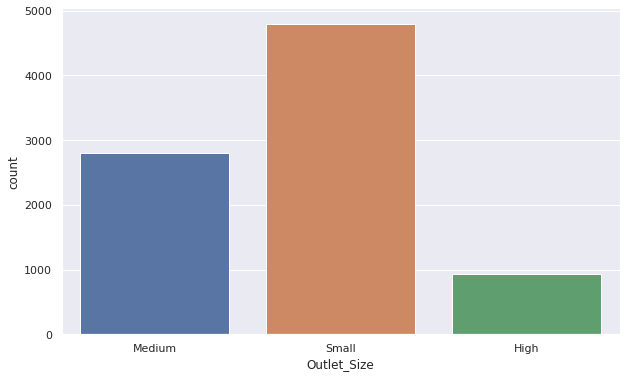

In [ ]:
#Outlet_Size_column
plt.figure(figsize=(10,6))
sns.countplot(x ='Outlet_Size', data = bigmart_data)
plt.show()

In [ ]:
bigmart_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
bigmart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)

In [ ]:
bigmart_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

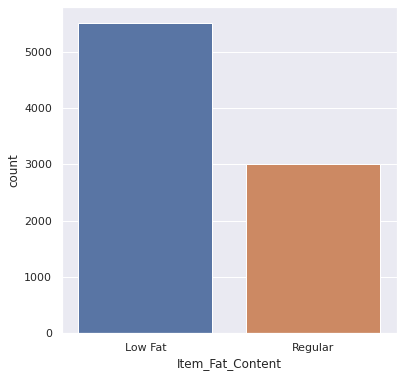

In [ ]:
#Item_Fat_Content_column
plt.figure(figsize=(6,6))
sns.countplot(x ='Item_Fat_Content', data = bigmart_data)
plt.show()

In [ ]:
bigmart_data.loc[bigmart_data['new_item_type'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
bigmart_data['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

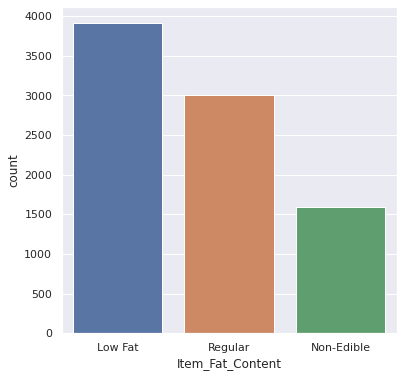

In [ ]:
#Item_Fat_Content_column adding after non-edible
plt.figure(figsize=(6,6))
sns.countplot(x ='Item_Fat_Content', data = bigmart_data)
plt.show()

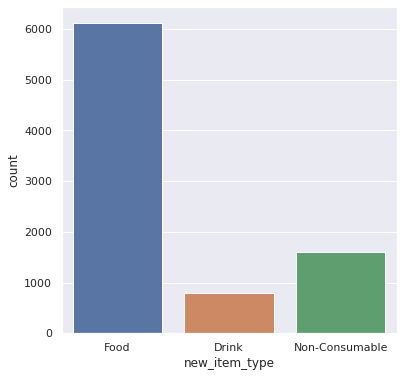

In [ ]:
#new_item_type_column
plt.figure(figsize=(6,6))
sns.countplot(x ='new_item_type', data = bigmart_data)
plt.show()

**Correlation Matrix**

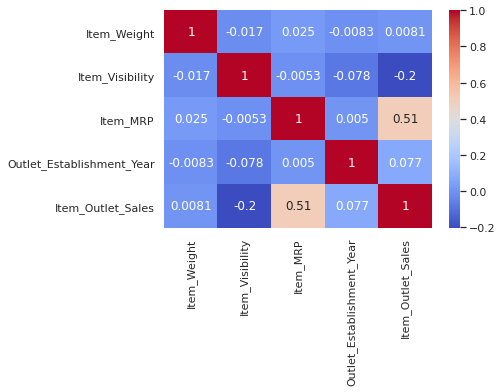

In [ ]:
corr = bigmart_data.corr()
sns.heatmap(corr, annot = True, cmap='coolwarm')

**Label Encoding**

In [ ]:
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,new_item_type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.225808,Food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.096776,Drink
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.648868,Food
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,6.597664,Food
4,NCD19,8.93,Non-Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.903451,Non-Consumable


In [ ]:
label = LabelEncoder()

In [ ]:
bigmart_data['Item_Identifier'] = label.fit_transform(bigmart_data['Item_Identifier'])
bigmart_data['Outlet'] = label.fit_transform(bigmart_data['Outlet_Identifier'])
cat_column = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'new_item_type']
for col in cat_column:
  bigmart_data[col] = label.fit_transform(bigmart_data[col])

In [ ]:
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,new_item_type,Outlet
0,156,9.30,0,0.016047,4,249.8092,OUT049,1999,1,0,1,8.225808,1,9
1,8,5.92,2,0.019278,14,48.2692,OUT018,2009,1,2,2,6.096776,0,3
2,662,17.50,0,0.016760,10,141.6180,OUT049,1999,1,0,1,7.648868,1,9
3,1121,19.20,2,0.066132,6,182.0950,OUT010,1998,2,2,0,6.597664,1,0
4,1297,8.93,1,0.066132,9,53.8614,OUT013,1987,0,2,1,6.903451,2,1


**Onehot encoding**

In [ ]:
bigmart_data = pd.get_dummies(bigmart_data, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'new_item_type'])
bigmart_data.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,Outlet_Size_1,Outlet_Size_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,new_item_type_0,new_item_type_1,new_item_type_2
0,156,9.30,0.016047,4,249.8092,OUT049,1999,8.225808,9,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,8,5.92,0.019278,14,48.2692,OUT018,2009,6.096776,3,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0
2,662,17.50,0.016760,10,141.6180,OUT049,1999,7.648868,9,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
3,1121,19.20,0.066132,6,182.0950,OUT010,1998,6.597664,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0
4,1297,8.93,0.066132,9,53.8614,OUT013,1987,6.903451,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1


**input spilt features**

In [ ]:
x = bigmart_data.drop(columns = ['Outlet_Identifier', 'Item_Outlet_Sales'])
y = bigmart_data['Item_Outlet_Sales']

In [ ]:
print(x)

      Item_Identifier  Item_Weight  ...  new_item_type_1  new_item_type_2
0                 156        9.300  ...                1                0
1                   8        5.920  ...                0                0
2                 662       17.500  ...                1                0
3                1121       19.200  ...                1                0
4                1297        8.930  ...                0                1
...               ...          ...  ...              ...              ...
8518              370        6.865  ...                1                0
8519              897        8.380  ...                1                0
8520             1357       10.600  ...                0                1
8521              681        7.210  ...                1                0
8522               50       14.800  ...                0                0

[8523 rows x 23 columns]


In [ ]:
print(y)

0       8.225808
1       6.096776
2       7.648868
3       6.597664
4       6.903451
          ...   
8518    7.929984
8519    6.310436
8520    7.085159
8521    7.521100
8522    6.642056
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


**Spliting Data into Train and test**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
print(x.shape, x_train.shape, x_test.shape)

(8523, 23) (6818, 23) (1705, 23)


In [ ]:
y_train

7173    7.416681
3315    7.991982
5932    7.820476
7872    6.897415
5946    3.848874
          ...   
1099    7.579910
2514    7.608066
6637    7.604756
2575    7.224909
7336    7.513136
Name: Item_Outlet_Sales, Length: 6818, dtype: float64

In [ ]:
y_test

1112    7.343204
1751    8.764990
7648    6.976914
7362    5.914905
5332    4.626947
          ...   
3503    8.356271
975     7.109396
6190    7.347931
32      8.029109
4433    8.609201
Name: Item_Outlet_Sales, Length: 1705, dtype: float64

**ML Model Training**

In [ ]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

**Linear Regression Model**

In [ ]:
def train (model, x_train, y_train):
  model.fit(x_train, y_train)
  pred = model.predict(x_train)
  cv_score = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
  cv_score = np.abs(np.mean(cv_score))
  cv_score_std = np.sqrt(np.mean(cv_score))
  lr_accuracy = round(model.score(x_train,y_train) *100 , 2)
  r2_score_p = r2_score(y_train, pred)
  print("Accuracy: ",lr_accuracy )
  print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, pred)))
  print("MSE:",mean_squared_error(y_train,pred))
  print("R2_Score: ",r2_score_p )
  print("CV_Score: ",cv_score)
  print("standard deviation: ",cv_score_std)

Model Report: Linear Regression
Accuracy:  72.26
RMSE : 0.5356
MSE: 0.28683210152097516
R2_Score:  0.7225968338404131
CV_Score:  0.28870171227384994
standard deviation:  0.5373096986597673


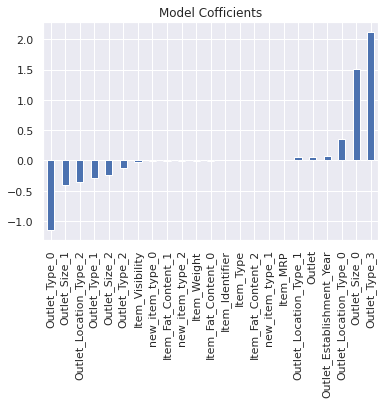

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
model = LinearRegression(normalize=True)
print("Model Report: Linear Regression")
train(model, x_train, y_train)
coef = pd.Series(model.coef_, x.columns).sort_values()
coef.plot(kind='bar',title="Model Cofficients")

Model Report: Ridge
Accuracy:  58.7
RMSE : 0.6535
MSE: 0.4270501081239044
R2_Score:  0.5869881666864194
CV_Score:  0.4283231636112806
standard deviation:  0.6544640277442914


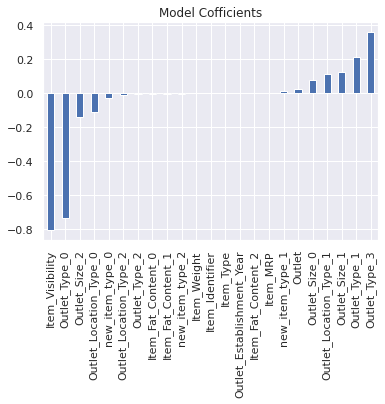

In [ ]:
model = Ridge(normalize=True)
print("Model Report: Ridge")
train(model, x_train, y_train)
coef = pd.Series(model.coef_, x.columns).sort_values()
coef.plot(kind='bar',title="Model Cofficients")

Model Report: Lasso
Accuracy:  26.38
RMSE : 0.8725
MSE: 0.7612136945239549
R2_Score:  0.2638094276573153
CV_Score:  0.761855148755895
standard deviation:  0.872843140980036


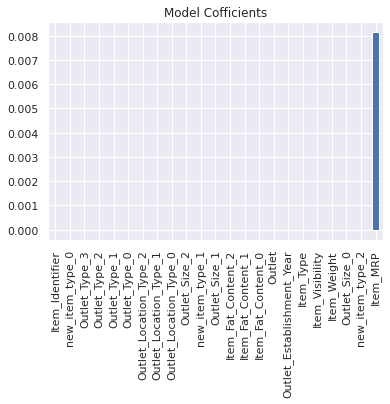

In [ ]:
model = Lasso()
print("Model Report: Lasso")
train(model, x_train, y_train)
coef = pd.Series(model.coef_, x.columns).sort_values()
coef.plot(kind='bar',title="Model Cofficients")

**Decision Tree Regressor**

Model Report : Decision Tree Regressor
Accuracy:  100.0
RMSE : 4.446e-06
MSE: 1.9769677319570817e-11
R2_Score:  0.9999999999808802
CV_Score:  0.5842186932101587
standard deviation:  0.7643420001610266


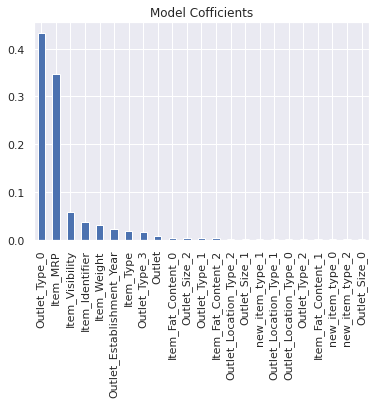

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
print("Model Report : Decision Tree Regressor")
train(model, x_train, y_train)
coef = pd.Series(model.feature_importances_, x.columns).sort_values(ascending=False)
coef.plot(kind='bar',title="Model Cofficients")

**Random Forest**

Model Report: Random Forest Regressor
Accuracy:  74.8
RMSE : 0.5105
MSE: 0.26056001550772706
R2_Score:  0.7480052863917364
CV_Score:  0.2717003880429042
standard deviation:  0.5212488734212326


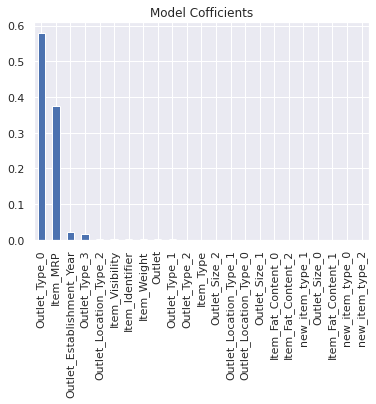

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100,max_depth=6, min_samples_leaf=50,n_jobs=4)
print("Model Report: Random Forest Regressor")
train(model, x_train, y_train)
coef = pd.Series(model.feature_importances_, x.columns).sort_values(ascending=False)
coef.plot(kind='bar',title="Model Cofficients")

**XGBoost Regressor**

In [ ]:
#prediction on training data
regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)
regressor.fit(x_train, y_train)
training_data_prediction = regressor.predict(x_train)
r2_train = metrics.r2_score(y_train, training_data_prediction)
xg_accuracy = round(regressor.score(x_train,y_train)*100,2)
r2_score(y_train, regressor.predict(x_train))
cv_score = cross_val_score(regressor, x_train,y_train, cv=10, scoring='neg_mean_squared_error')
cv_score = np.abs(np.mean(cv_score))
cv_score_std = np.sqrt(np.mean(cv_score))
print("Model Report: XGBRegressor")
print("Accuracy: ",xg_accuracy )
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, regressor.predict(x_train))))
print("MSE:",mean_squared_error(y_train,regressor.predict(x_train)))
print("R2_Score: ",r2_train )
print("CV_Score: ",cv_score)
print("standard deviation: ",cv_score_std)

[10:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
#prediction on test data
test_data_prediction = regressor.predict(x_test)
r2_test = metrics.r2_score(y_test, test_data_prediction)
regressor = XGBRegressor(n_estimators=1000, learning_rate=0.05)
regressor.fit(x_test, y_test)
xg_accuracy = round(regressor.score(x_test,y_test)*100,2)
cv_score = cross_val_score(regressor, x_test,y_test, cv=5, scoring='neg_mean_squared_error')
cv_score = np.abs(np.mean(cv_score))
cv_score_std = np.sqrt(np.mean(cv_score))
print("Model Report: XGBRegressor")
print("Accuracy: ",xg_accuracy )
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, regressor.predict(x_train))))
print("MSE:",mean_squared_error(y_train,regressor.predict(x_train)))
print("R2_Score: ",r2_test )
print("CV_Score: ",cv_score)
print("standard deviation: ",cv_score_std)

[10:25:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:25:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Report: XGBRegressor
Accuracy:  88.86
RMSE : 0.5565
MSE: 0.3097373690617788
R2_Score:  0.7211471624558792
CV_Score:  0.32199415408130716
standard deviation:  0.567445287302051


**Gradient Boost**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 600, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gbr = GradientBoostingRegressor(**params).fit(x_train,y_train)
params1 = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.2, 'loss': 'huber','alpha':0.95}
gbr1 = GradientBoostingRegressor(**params).fit(x_train,y_train)

params2 = {'n_estimators': 400, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gbr2 = GradientBoostingRegressor(**params).fit(x_train,y_train)

In [ ]:
rf_accuracy = round(gbr.score(x_train,y_train)*100,2)
rf_accuracy

94.08

In [ ]:
rf_accuracy1 = round(gbr1.score(x_train,y_train)*100,2)
rf_accuracy1

94.36

In [ ]:
rf_accuracy2 = round(gbr2.score(x_train,y_train)*100,2)#Best score
rf_accuracy2

94.27

In [ ]:
cv_score = cross_val_score(gbr2, x_train,y_train, cv=10, scoring='neg_mean_squared_error')

In [ ]:
  print("Model Report: Gradient Boost")
  print("Accuracy: ",rf_accuracy1 )
  pred = gbr2.predict(x_train)
  print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, pred)))
  print("MSE:",mean_squared_error(y_train,pred))
  print("R2_Score: ",r2_score(y_train, pred) )
  cv_score = np.abs(np.mean(cv_score))
  print("CV_Score: ",cv_score)
  print("standard deviation: ",np.sqrt(np.abs(cv_score)))

Model Report: Gradient Boost
Accuracy:  94.36
RMSE : 0.2434
MSE: 0.059250039419092855
R2_Score:  0.942697667231871
CV_Score:  0.32141721243369703
standard deviation:  0.5669366917334748


**SVM**

In [ ]:
from sklearn.svm import SVR
sv_regressor = SVR(kernel='rbf')
sv_regressor.fit(x_train,y_train)
sv_accuracy = round(sv_regressor.score(x_test,y_test)*100,2)
yfit = sv_regressor.predict(x_train)
score = sv_regressor.score(x_train,y_train)
print("Accuracy: ",sv_accuracy )
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_train, sv_regressor.fit(x_train,y_train).predict(x_train))))
print("MSE:", mean_squared_error(y_train, yfit))
print("R2_Score: ",score)  
cv_score = cross_val_score(sv_regressor, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
cv_score = np.abs(np.mean(cv_score))
print("CV_Score: ",cv_score)
print("standard deviation: ",np.sqrt(np.abs(cv_score)))

Accuracy:  21.25
RMSE : 0.9008
MSE: 0.8113515314725334
R2_Score:  0.21531975498756462
CV_Score:  0.8130418373801673
standard deviation:  0.9016883260751285
